# Text Mining Assignment

Extract reviews of any product from ecommerce website like amazon

Perform emotion mining

## Part 1: Web Scrapping

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
headers = {
    'authority': 'www.amazon.in',
    'accept-language': 'en-US,en;q=0.9',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
    'referer': 'https://www.amazon.in/s?k=phone&crid=RAWCN8NS3GDA&sprefix=pho%2Caps%2C248&ref=nb_sb_noss_2'
}

In [10]:
def scrap_reviews(url):
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.text,"html.parser")
    review_divs = soup.find_all('div', class_='a-section review aok-relative')

    reviews = []
    for review_div in review_divs:
        reviewer_name = review_div.find('span', class_='a-profile-name').text.strip()
        review_title = review_div.find('a', class_='review-title-content').text.strip()
        review_body = review_div.find('span', class_='review-text-content').text.strip()
        review_rating = review_div.find('i', class_='review-rating').span.text.strip()
        reviews.append({'name':reviewer_name,'title':review_title,'body':review_body,'rating':review_rating})
    
    return pd.DataFrame(reviews)

#### Extracting reviews of Samsung Galaxy s20 FE mobile from amazon.in

In [11]:
url_first_page = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_unknown?ie=UTF8&reviewerType=all_reviews&pageNumber=1&filterByStar=five_star"
data = scrap_reviews(url_first_page)

Downloading five star reviews

In [14]:
for i in range(2,133):
    url_five_star = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_unknown?ie=UTF8&reviewerType=all_reviews&pageNumber="+str(i)+"&filterByStar=five_star"
    new_data = scrap_reviews(url_five_star)
    data = pd.concat([data,new_data],axis=0,ignore_index=True)

Downloading one star reviews

In [15]:
for i in range(1,133):
    url_one_star = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_getr_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber="+str(i)+"&filterByStar=one_star"
    new_data = scrap_reviews(url_one_star)
    data = pd.concat([data,new_data],axis=0,ignore_index=True)

Downloading three star reviews

In [17]:
for i in range(1,54):
    url_three_star = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_getr_d_paging_btm_next_53?ie=UTF8&reviewerType=all_reviews&pageNumber="+str(i)+"&filterByStar=three_star"
    new_data = scrap_reviews(url_three_star)
    data = pd.concat([data,new_data],axis=0,ignore_index=True)

Shuffling reviews

In [20]:
data = data.sample(frac=1).reset_index(drop=True)

In [21]:
data.to_csv('galaxy_s20FE.csv',encoding='utf-8',index=False)

## Part 2: Emotion Mining 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

import re
import unicodedata
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

2023-05-14 16:53:24.049071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 16:54:06.542486: E tensorflow/compiler/xla/stream_executor/rocm/rocm_driver.cc:302] failed call to hipInit: HIP_ERROR_NoDevice


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/aniket/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aniket/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/aniket/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/aniket/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### EDA

In [4]:
rawdata = pd.read_csv('galaxy_s20FE.csv',encoding='utf-8')

In [5]:
rawdata.head()

,name,title,body,rating
0,Syed Basheeuddin,Worst Phone ever Service Centre is also not co...,Product and its service worst experience,1.0 out of 5 stars
1,Lalit Kumar,Nice product,Will write a review later.Working great till d...,5.0 out of 5 stars
2,Anand,Phone screen was dead within 15 days...worst p...,"Camera, screen touch and processor is good...b...",1.0 out of 5 stars
3,TS,"Phone not working, Amazon not replacing",Bought this phone seeing the good ratings but ...,1.0 out of 5 stars
4,Ashish Goyal,Expected better display quality,The display has issues. Auto brightness does n...,3.0 out of 5 stars


In [6]:
rawdata.isna().sum()

name       1
title      0
body      74
rating     0
dtype: int64

In [7]:
rawdata.duplicated(['title','body']).sum()

25

In [8]:
rawdata.drop_duplicates(['title','body'],inplace=True)

<AxesSubplot:xlabel='rating', ylabel='count'>

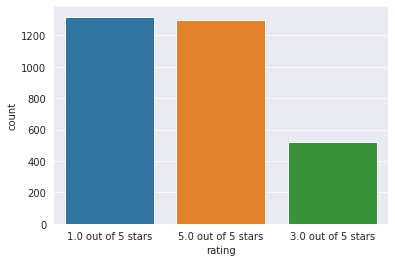

In [9]:
sns.countplot(x = rawdata['rating'])

Combining title and body and only considering that as our final data

In [10]:
data = pd.DataFrame(rawdata['title']+' '+rawdata['body'].fillna(''), columns=['review'])

In [11]:
data.duplicated().sum()

0

In [12]:
data.isna().sum()

review    0
dtype: int64

<AxesSubplot:xlabel='review', ylabel='Count'>

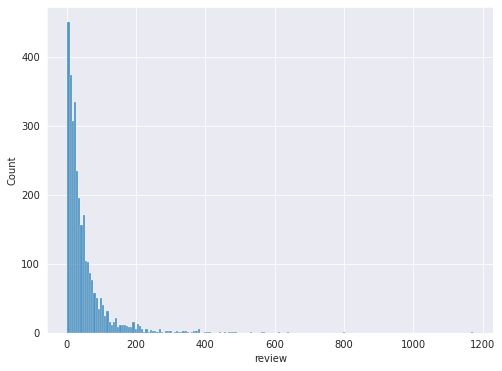

In [13]:
plt.figure(figsize=(8,6))
word_count = data['review'].apply(lambda x: len(str(x).split(" ")))
sns.histplot(word_count)

Sample review

In [221]:
data['review'][2]

'Phone screen was dead within 15 days...worst phone ever Camera, screen touch and processor is good...but samsung is seeling defective product through amazon...releasing its defective closing stock on sale....dont buy...i am also regretting....your screen will get black within a month'

Checking any links present

In [222]:
data['review'].str.contains(r'http[s]?://[^\s]+',regex=True).value_counts()

False    3135
Name: review, dtype: int64

Checking any \n symbol present

In [223]:
data['review'].str.contains('\n').sum()

111

Checking any [] present

In [224]:
data['review'].str.contains(r'\[.*?\]').sum()

3

Checking any special characters and numbers

In [225]:
data['review'].str.contains(r'[^\w\s]|[\d]').sum()

2672

Getting rid of all those characters

In [226]:
data['cleaned'] = data['review'].str.replace(r"\n|[^\w\s]|[\d]|\[.*?\]",'',regex=True)

Lowercasing all words

In [227]:
data['cleaned'] = data['cleaned'].str.lower()

In [228]:
#from textblob import TextBlob
#data['cleaned'].apply(lambda x: str(TextBlob(x).correct()))

#### Top Named Entity

In [229]:
def extract_named_entities(tweet):
    doc = nlp(tweet)
    entities = [entity.text for entity in doc.ents]
    return entities

name_list = data['cleaned'].apply(extract_named_entities)
name_list = [entity for sublist in name_list for entity in sublist]

<AxesSubplot:>

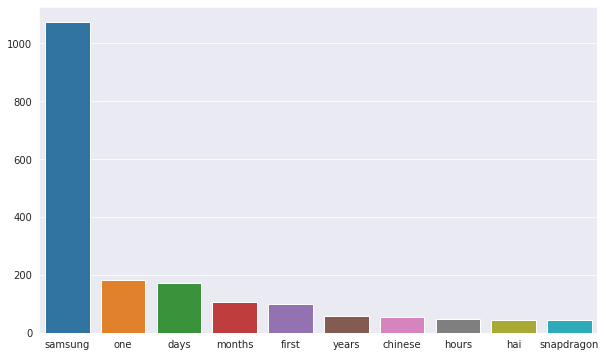

In [230]:
entity_counts = Counter(name_list)
top_10_names = [entity[0] for entity in entity_counts.most_common(10)]
top_10_counts = [entity[1] for entity in entity_counts.most_common(10)]
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_names,y=top_10_counts)

In [231]:
def remove_named_entities(text):
    for word in ['samsung','amazon','one','days','months','first','years','hai','phone']:
        return re.sub(word,'',text)

data['cleaned'] = data['cleaned'].apply(remove_named_entities)

#### Removing stopwords

In [232]:
stop = stopwords.words('english')

with open('stop.txt') as f:
    extra_stop = [word.strip('\n') for word in f.readlines()]

stop.extend(extra_stop)

In [233]:
data['without_stopwords'] = data['cleaned'].apply(lambda x: [x for x in x.split() if x not in stop])

In [234]:
data.head()

,review,cleaned,without_stopwords
0,Worst Phone ever Service Centre is also not co...,worst phone ever service centre is also not co...,"[worst, phone, service, centre, cooperative, p..."
1,Nice product Will write a review later.Working...,nice product will write a review laterworking ...,"[nice, product, write, review, laterworking, g..."
2,Phone screen was dead within 15 days...worst p...,phone screen was dead within daysworst phone ...,"[phone, screen, dead, daysworst, phone, camera..."
3,"Phone not working, Amazon not replacing Bought...",phone not working amazon not replacing bought ...,"[phone, working, amazon, replacing, bought, ph..."
4,Expected better display quality The display ha...,expected better display quality the display ha...,"[expected, display, quality, display, issues, ..."


#### Lemmatization

In [235]:
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['without_stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x]))

### Sentiment Analysis

In [236]:
sia = SentimentIntensityAnalyzer()

data['score'] = data['lemmatized'].apply(lambda tweet: sia.polarity_scores(tweet)['compound'])
data['sentiment'] = data['score'].apply(lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral')

In [240]:
data.head()

,review,cleaned,without_stopwords,lemmatized,score,sentiment
0,Worst Phone ever Service Centre is also not co...,worst phone ever service centre is also not co...,"[worst, phone, service, centre, cooperative, p...",worst phone service centre cooperative product...,-0.8481,Negative
1,Nice product Will write a review later.Working...,nice product will write a review laterworking ...,"[nice, product, write, review, laterworking, g...",nice product write review laterworking great t...,0.7845,Positive
2,Phone screen was dead within 15 days...worst p...,phone screen was dead within daysworst phone ...,"[phone, screen, dead, daysworst, phone, camera...",phone screen dead daysworst phone camera scree...,-0.8779,Negative
3,"Phone not working, Amazon not replacing Bought...",phone not working amazon not replacing bought ...,"[phone, working, amazon, replacing, bought, ph...",phone working amazon replacing bought phone go...,0.4404,Positive
4,Expected better display quality The display ha...,expected better display quality the display ha...,"[expected, display, quality, display, issues, ...",expected display quality display issue auto br...,0.6705,Positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

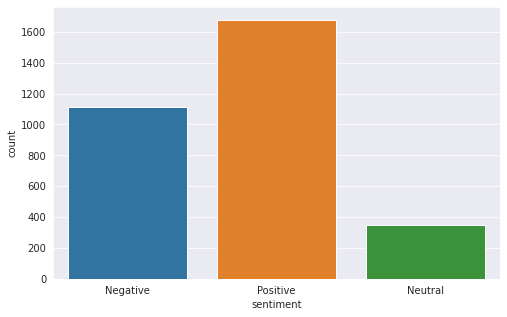

In [237]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='sentiment')

##### Most common words in positive comments

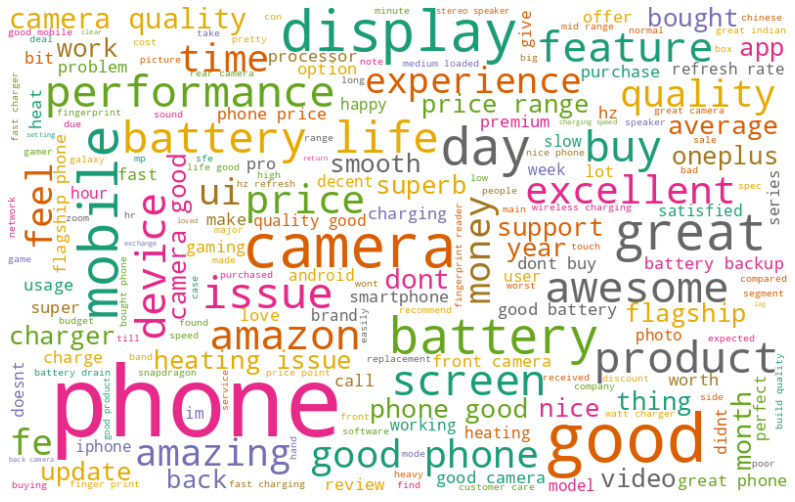

In [238]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2',background_color='white').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

all_words = ' '.join([text for text in data[data['sentiment']=='Positive']['lemmatized']])
generate_wordcloud(all_words)

##### Most common words in negative tweets

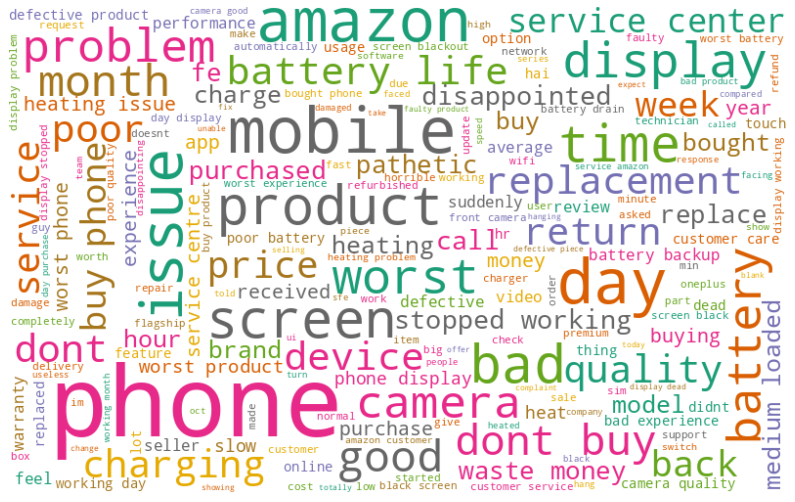

In [239]:
all_words = ' '.join([text for text in data[data['sentiment']=='Negative']['lemmatized']])
generate_wordcloud(all_words)

### Feature Extraction for key words
TF-IDF (Term Frequency-Inverse Document Frequency)

In [241]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
tfidf_features = vectorizer.fit_transform(data['lemmatized'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), 
                        columns=vectorizer.get_feature_names_out())

In [242]:
tfidf_df.head()

,aa,aap,ability,abruptly,absent,absolute,absolutely,abt,accept,acceptable,...,बटर,मन,मबइल,महन,यह,लए,लकन,लय,हई,हन
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
target_variable = data['sentiment'].apply(lambda x: 0 if x=='Negative' else 1)

In [244]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df,target_variable,test_size=0.3,random_state=42)

### Model Building

In [245]:
classifier = MultinomialNB()
classifier.fit(x_train,y_train)

MultinomialNB()

In [246]:
y_pred = classifier.predict(x_test)

In [247]:
confusion_matrix(y_test,y_pred,labels=[True,False])

array([[561,  64],
       [106, 210]])

Accuracy

In [248]:
accuracy_score(y_test,y_pred)*100

81.93411264612115